In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [2]:
def get_obj_img_points():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints

In [7]:
def save_to_pickle(objpoints, imgpoints, imageName, pickleName="../camera_cal/wide_dist_pickle.p"):
    img = cv2.imread(imageName)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    #dst = cv2.undistort(img, mtx, dist, None, mtx)
    #name = '../camera_cal/undist_'+image.split('/')[-1]
    #cv2.imwrite(name, dst)
    
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open(pickleName, "wb" ) )

In [9]:
def get_from_pickle(pickleName="../camera_cal/wide_dist_pickle.p"):
    dist_pickle = pickle.load( open(pickleName , "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    return mtx, dist

In [26]:
def perspective_unwarp(img, mtx, dist, src, dst):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) Convert to grayscale
    #gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    #ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # 4) If corners found: 
    #if ret == True:
            # a) draw corners
    #        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)

            # Grab the image shape
    #        img_size = (gray.shape[1], gray.shape[0])

    img_size = (img.shape[1], img.shape[0])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

In [14]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scale_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scale_sobel)
    binary_output[(scale_sobel >= thresh[0]) & (scale_sobel <= thresh[1])] = 1
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

In [16]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize= sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize= sobel_kernel)

    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2+sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scale_sobel)
    binary_output[(scale_sobel >= mag_thresh[0]) & (scale_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

In [17]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize= sobel_kernel)
    #print(sobelx.shape)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize= sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1    
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

In [18]:
def hls_select(img, channel='s', thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    if channel == 's':
        cha = hls_img[:,:,2]
    elif channel == 'h':
        cha = hls_img[:,:,0]
    elif channel == 'l':
        cha = hls_img[:,:,1]
    binary = np.zeros_like(cha)
    binary[(cha > thresh[0]) & (cha <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary

In [20]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

In [41]:
def draw(image, processed_image):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image, cmap='gray')
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result, cmap='gray')
    ax2.set_title('Processed Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=2., bottom=0.)

In [21]:
src = np.float32([[190, 720], [589, 457], [698, 457], [1145,720]])
dst = np.float32([[340, 720], [340, 0], [995, 0], [995, 720]])

objpoints, imgpoints = get_obj_img_points()

mtx,dist = get_from_pickle()

image = mpimg.imread('../test_images/straight_lines1.jpg')

In [46]:
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(20, 100))

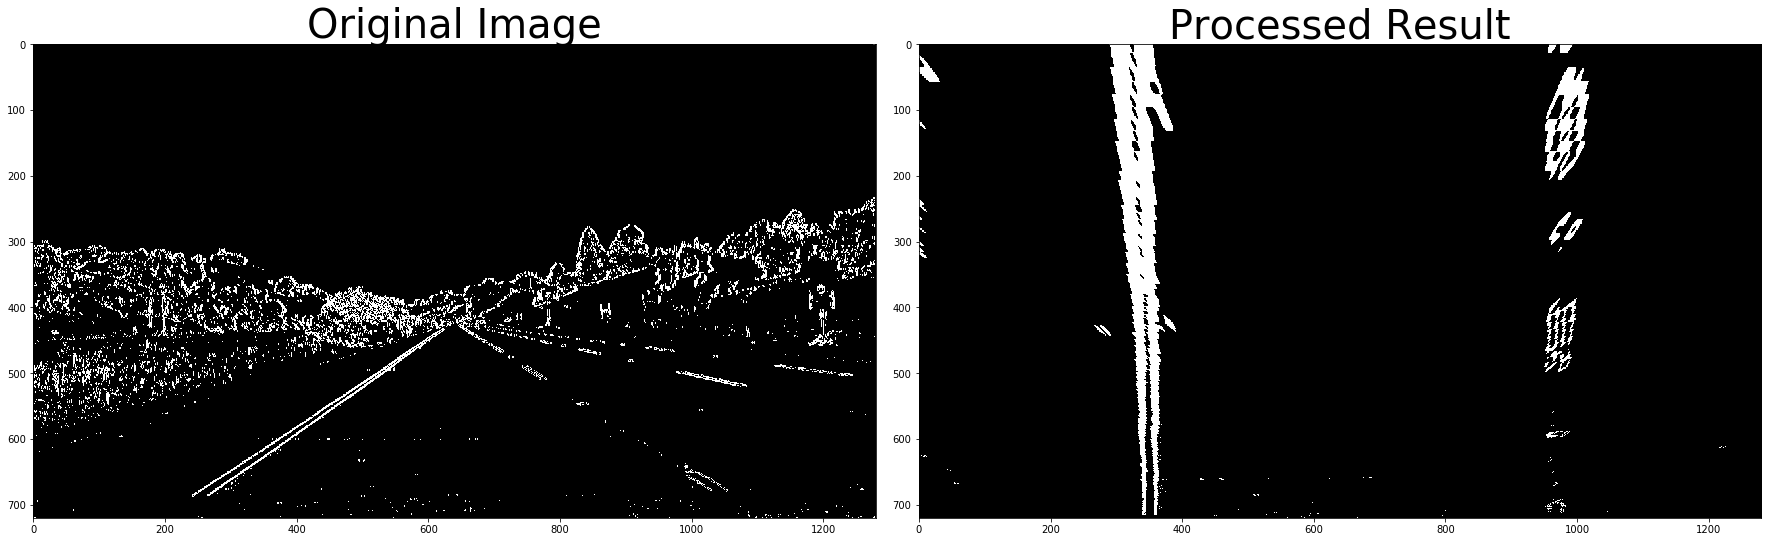

In [47]:
result, M = perspective_unwarp(gradx, mtx, dist, src, dst)
draw(gradx, result)

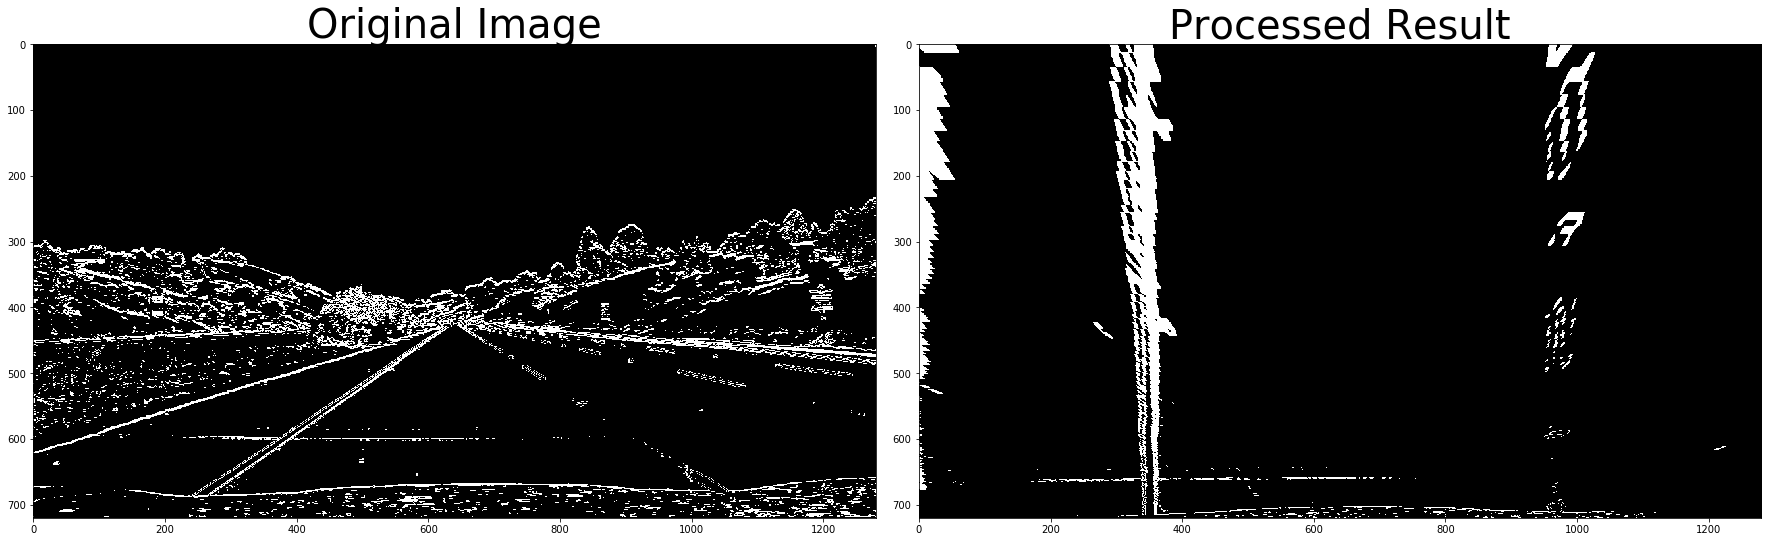

In [48]:
result, M = perspective_unwarp(grady, mtx, dist, src, dst)
draw(grady, result)

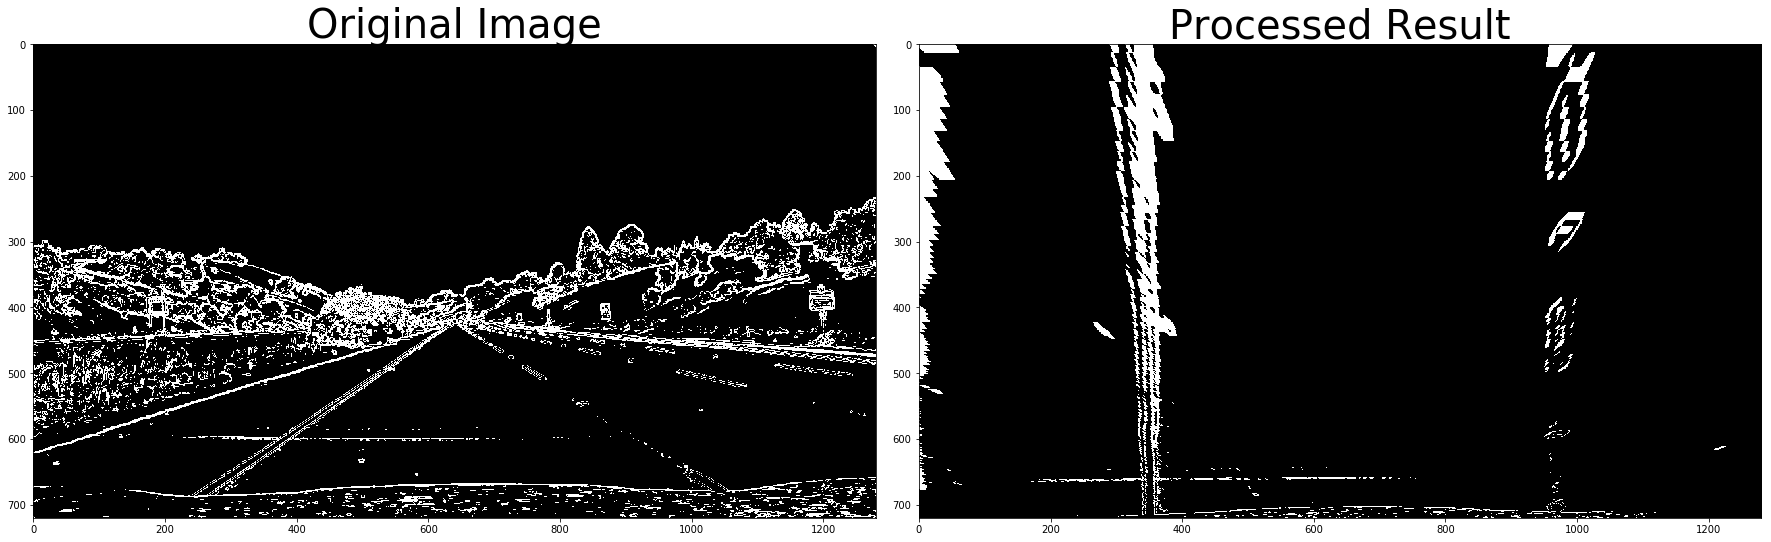

In [42]:
mag_image = mag_thresh(image, sobel_kernel=3, mag_thresh=(20, 100))
result, M = perspective_unwarp(mag_image, mtx, dist, src, dst)
draw(mag_image, result)

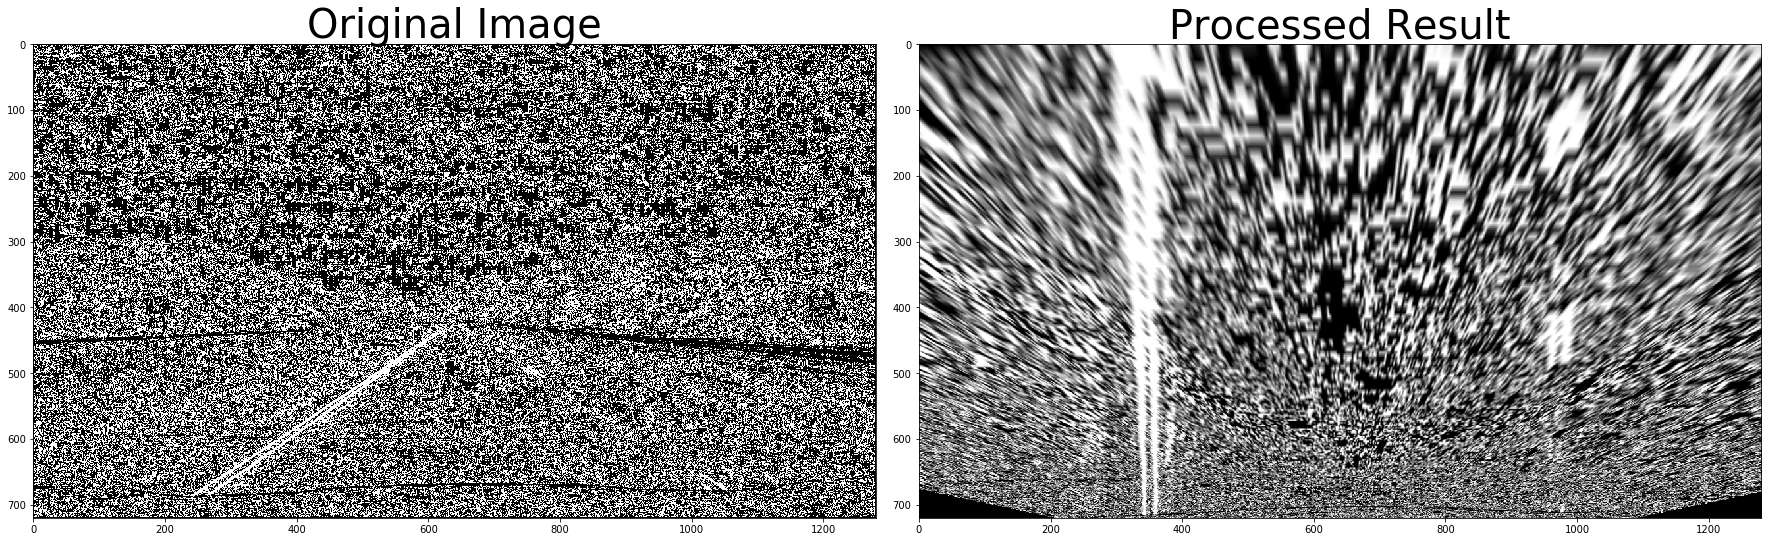

In [44]:
dir_image = dir_threshold(image, sobel_kernel=3, thresh=(0.6, 1.3))
result, M = perspective_unwarp(dir_image, mtx, dist, src, dst)
draw(dir_image, result)

In [49]:
s_binary = hls_select(image, channel='s', thresh=(90, 255))
h_binary = hls_select(image, channel='h', thresh=(90, 255))
l_binary = hls_select(image, channel='l', thresh=(90, 255))


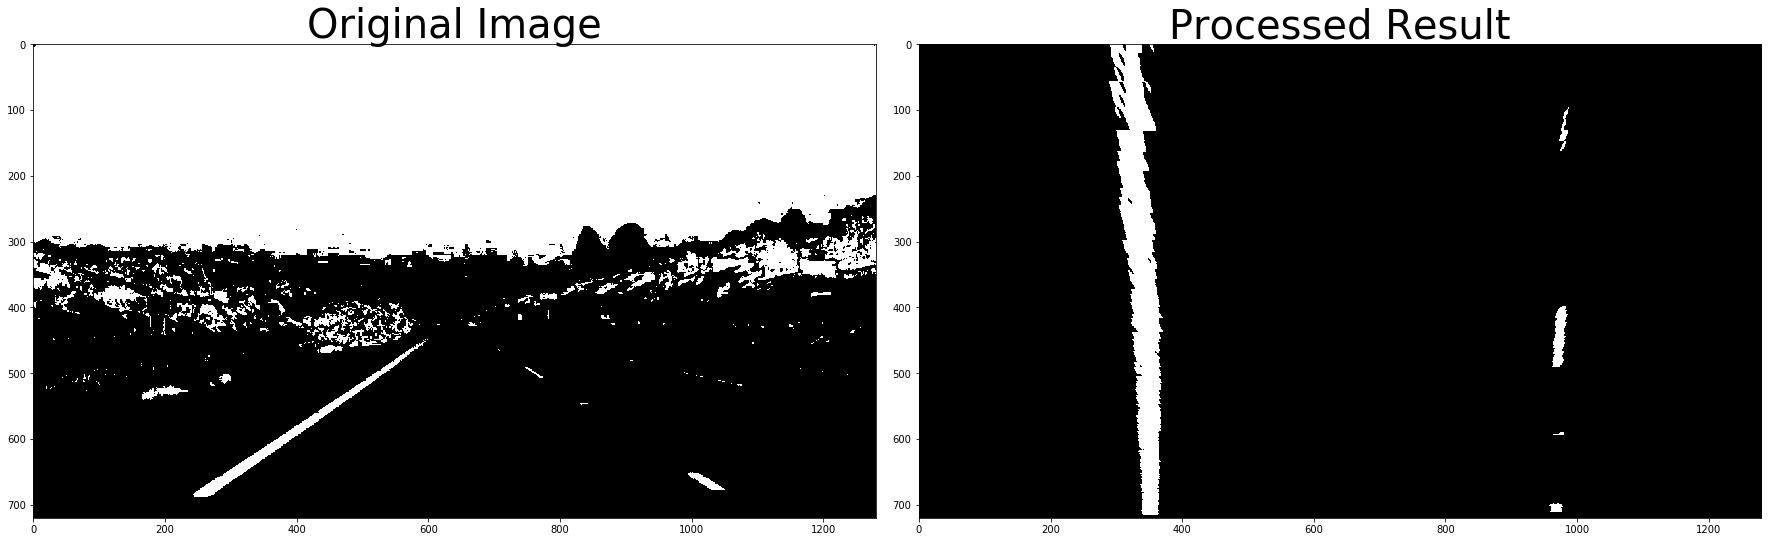

In [51]:
result, M = perspective_unwarp(s_binary, mtx, dist, src, dst)
draw(s_binary, result)

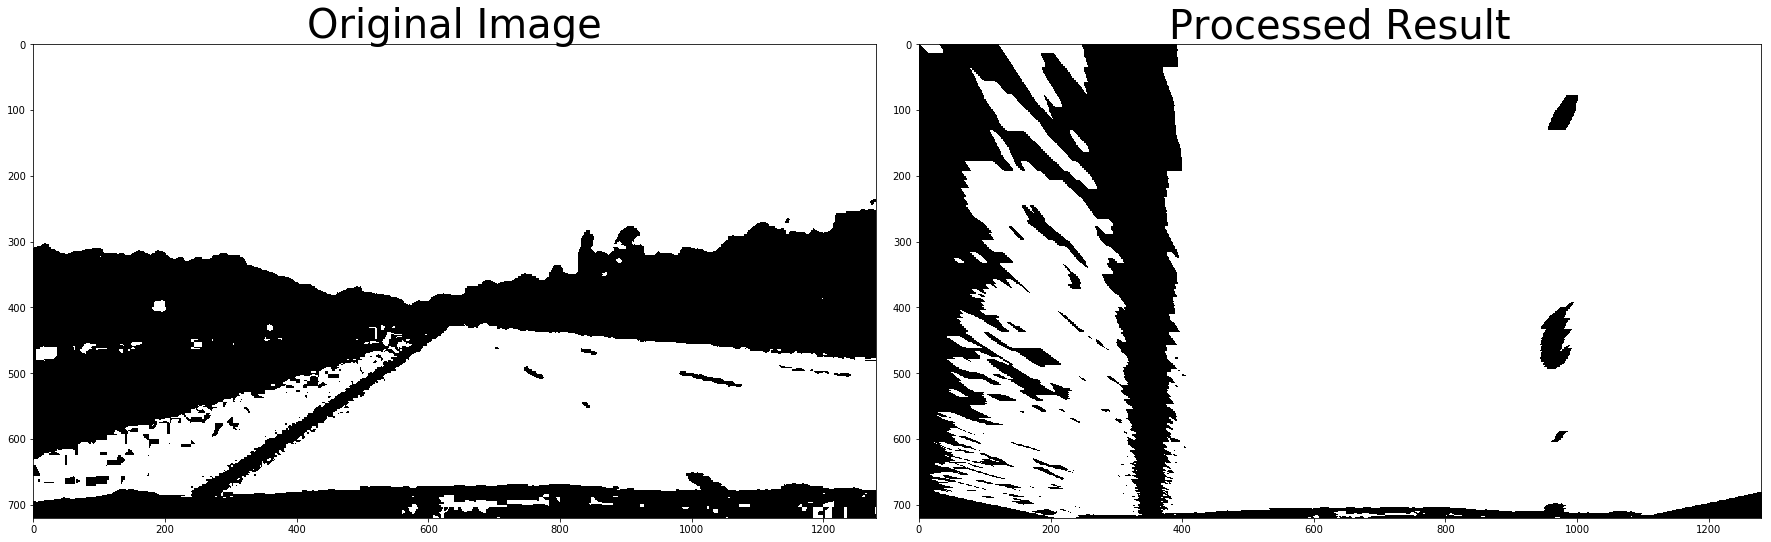

In [52]:
result, M = perspective_unwarp(h_binary, mtx, dist, src, dst)
draw(h_binary, result)

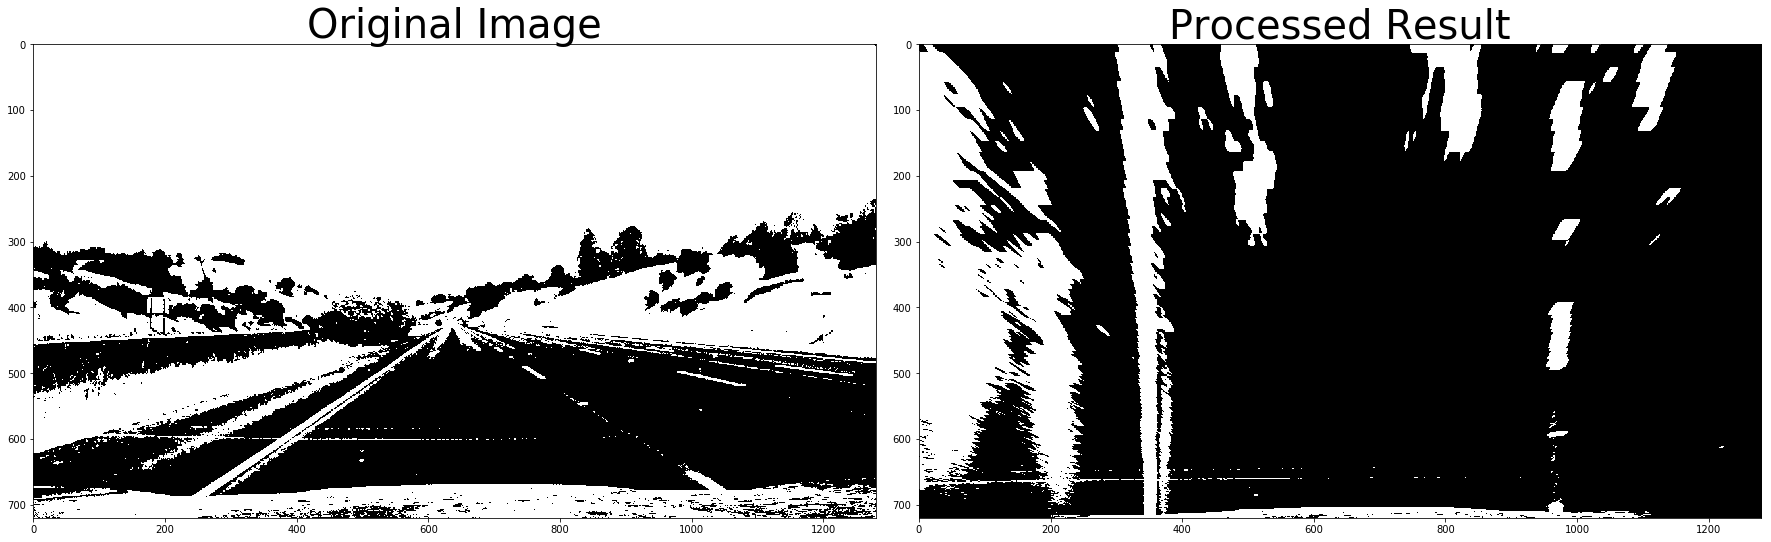

In [53]:
result, M = perspective_unwarp(l_binary, mtx, dist, src, dst)
draw(l_binary, result)